In [1]:
#!/usr/bin/python3

import requests
import hashlib
import os.path
import datetime
import re
import numpy
import datetime
import pandas as pd
from prettytable import PrettyTable
from dateutil.parser import parse as parsedate

FILE_PADS = "sites.tsv"
FILE_TEMP2 = "sites.tmp"
FILE_DATA = "launchdata.tsv"
FILE_TEMP = "launchdata.tmp"

In [2]:
def update_GCAT():
	
	if os.path.isfile(FILE_TEMP): os.remove(FILE_TEMP)
	
	print('Checking for GCAT update...')
	url = 'https://planet4589.org/space/gcat/tsv/launch/launch.tsv'
	response = requests.get(url, allow_redirects=True)
	open(FILE_TEMP,"wb").write(response.content)


	r = requests.head(url)
	url_time = r.headers['last-modified']
	url_date = parsedate(url_time)

	md5_hash = hashlib.md5
	with open(FILE_TEMP,"rb") as f:
		bytes = f.read()
		readable_hash = hashlib.md5(bytes).hexdigest()

	if os.path.isfile(FILE_DATA):
		with open(FILE_DATA,"rb") as g:
			bytes = g.read()
			readable_hash2 = hashlib.md5(bytes).hexdigest()
			if readable_hash == readable_hash2: 
				os.remove(FILE_TEMP)
				print ("No updates found!")
			else: 
				os.remove(FILE_DATA)
				os.rename(FILE_TEMP,FILE_DATA)
				print ("New GCAT version installed, date:",url_date)
	else:
		os.rename(FILE_TEMP,FILE_DATA)
		print ("No old GCAT found, fetched latest version from date",url_date)

In [3]:
def update_PADS():

	if os.path.isfile(FILE_TEMP2): os.remove(FILE_TEMP2)

	print('Checking for PADS update...')
	url = 'https://planet4589.org/space/gcat/tsv/tables/sites.tsv'
	response = requests.get(url, allow_redirects=True)
	open(FILE_TEMP2,"wb").write(response.content)


	r = requests.head(url)
	url_time = r.headers['last-modified']
	url_date = parsedate(url_time)

	md5_hash = hashlib.md5
	with open(FILE_TEMP2,"rb") as f:
		bytes = f.read()
		readable_hash = hashlib.md5(bytes).hexdigest()

	if os.path.isfile(FILE_PADS):
		with open(FILE_PADS,"rb") as g:
			bytes = g.read()
			readable_hash2 = hashlib.md5(bytes).hexdigest()
			if readable_hash == readable_hash2: 
				os.remove(FILE_TEMP2)
				print ("No updates found!")
			else: 
				os.remove(FILE_PADS)
				os.rename(FILE_TEMP2,FILE_PADS)
				print ("New PADS version installed, date:",url_date)
	else:
		os.rename(FILE_TEMP2,FILE_PADS)
		print ("No old PADS found, fetched latest version from date",url_date)

In [4]:
if not os.path.isfile(FILE_DATA): update_GCAT()
if not os.path.isfile(FILE_PADS): update_PADS()

In [5]:
df = pd.read_csv(FILE_DATA, sep='\t', header=None, skiprows=lambda x: x<2, names=['Launch_Tag', 'Launch_JD', 'Launch_Date', 'LV_Type', 'Variant', 'Flight_ID', 'Flight', 'Mission', 'FlightCode', 'Platform', 'Launch_Site', 'Launch_Pad', 'Ascent_Site', 'Ascent_Pad', 'Apogee', 'Apoflag', 'Range', 'RangeFlag', 'Dest', 'Agency', 'Launch_Code', 'Group', 'Category', 'LTCite', 'Cite', 'Notes'])
pads = pd.read_csv(FILE_PADS, sep='\t', header=None, skiprows=lambda xx: xx<2, names=['Site', 'Code', 'UCode', 'Type', 'StateCode', 'TStart', 'TStop', 'ShortName', 'Name', 'Location', 'Longitude', 'Latitude', 'Error', 'Parent', 'ShortEName', 'EName', 'Group', 'UName'])

## Filtering suborbital launches
df = df[df["Launch_Tag"].str.contains("-S") == False]
df = df[df["Launch_Tag"].str.contains("-A") == False]
df = df[df["Launch_Tag"].str.contains("-M") == False]
df = df[df["Launch_Tag"].str.contains("-W") == False]
df = df[df["Launch_Tag"].str.contains("-Y") == False]
df = df[df["Launch_Tag"].str.contains("-U") == False]
df = df[df["Launch_Tag"].str.contains("2014-000") == False]

ldata = df.to_numpy()
pdata = pads.to_numpy()

ldata_rows = len(df.index)
pdata_rows = len(pads.index)

i = 0
j = 0
country = []
status =[] 

while i<ldata_rows:
	j = 0
	while j<pdata_rows:
		if ldata[i][10].strip() == pdata[j][0].strip(): 
			tmp_country = pdata[j][4]
			if tmp_country == "DZ": tmp_country = "EU"
			if tmp_country == "J": tmp_country = "JP"
			if tmp_country == "GUF": tmp_country = "EU"
			if tmp_country == "AU": tmp_country = "EU"
			if tmp_country == "NZ": tmp_country = "US"
			if tmp_country == "TTPI": tmp_country = "US"
			if tmp_country == "ESCN": tmp_country = "US"
			if tmp_country == "KE": tmp_country = "US"
			if tmp_country == "KI": tmp_country = "RU"
			if tmp_country == "SU": tmp_country = "RU"
#			if (int(ldata[i][1]) > int(2448615.58) and tmp_country == "SU"): tmp_country = "RU"
			country.append(tmp_country)
		j+=1
	# Catching failed launches

	tmp_status = ldata[i][0]
	if "-F" in str(tmp_status): 
		status.append("F")
	else:
		status.append("S")
	i+=1

df['Country'] = country
df['Status'] = status
ldata = df.to_numpy()

ttable = PrettyTable()
ttable.align = "l"
ttable.field_names = ["ID", "Date", "Rocket", "Series", "Sat * Mission", "Or", "LSite"]

i = 1
while i<10:
	ttable.add_row([ldata[-i][0].strip(), ldata[-i][2] if ":" not in ldata[-i][2] else ldata[-i][2][:-3], ldata[-i][3] if len(ldata[-i][4])<2 else ldata[-i][3]+" / "+ldata[-i][4], ldata[-i][5], ldata[-i][6] if ldata[-i][6].strip() == ldata[-i][7].strip() else ldata[-i][6].strip() +" ("+ldata[-i][7].strip()+")", ldata[-i][26], ldata[-i][10] +"+"+ ldata[-i][11]])
	i+=1
    
list_recent_launches = str(ttable)

In [6]:
# Get current year statistics
today = datetime.date.today()
year = today.year
curr_year = str(year)

l_succ_curr = 0 # nr. succese din anul curent
l_fail_curr = 0 # nr. lansări eșuate din anul curent
i = 0

l_succ_country = [0] * 12
l_tot_country = [0] * 12
l_fail_country = [0] * 12

while i<ldata_rows:
    if curr_year in str(ldata[i][2]) and "F" not in str(ldata[i][0]): 
        l_succ_curr+=1
        if ldata[i][26] == "US": l_succ_country[0]+=1
        if ldata[i][26] == "RU": l_succ_country[1]+=1
        if ldata[i][26] == "CN": l_succ_country[2]+=1
        if ldata[i][26] == "EU": l_succ_country[3]+=1
        if ldata[i][26] == "JP": l_succ_country[4]+=1
        if ldata[i][26] == "IN": l_succ_country[5]+=1
        if ldata[i][26] == "IR": l_succ_country[6]+=1
        if ldata[i][26] == "IL": l_succ_country[7]+=1
        if ldata[i][26] == "KR": l_succ_country[8]+=1
        if ldata[i][26] == "KP": l_succ_country[9]+=1
        
    if curr_year in str(ldata[i][2]) and "F" in str(ldata[i][0]): 
        l_fail_curr+=1
        if ldata[i][26] == "US": l_fail_country[0]+=1
        if ldata[i][26] == "RU": l_fail_country[1]+=1
        if ldata[i][26] == "CN": l_fail_country[2]+=1
        if ldata[i][26] == "EU": l_fail_country[3]+=1
        if ldata[i][26] == "JP": l_fail_country[4]+=1
        if ldata[i][26] == "IN": l_fail_country[5]+=1
        if ldata[i][26] == "IR": l_fail_country[6]+=1
        if ldata[i][26] == "IL": l_fail_country[7]+=1
        if ldata[i][26] == "KR": l_fail_country[8]+=1
        if ldata[i][26] == "KP": l_fail_country[9]+=1
    i+=1

i = 0
while i<10:
    l_tot_country[i] = l_succ_country[i] + l_fail_country[i]
    i+=1
    
l_tot_curr = l_succ_curr + l_fail_curr

In [7]:
def racheta(nume):
    i = 0
    j = 0
    rtable = PrettyTable()
    rtable.align = "l"
    rtable.field_names = ["ID", "Date", "Rocket", "Series", "Sat * Mission", "Or", "LSite", "R"]
    r_launches = 0
    r_fail = 0
    while i<ldata_rows:
        if nume in ldata[i][3]: 
            rtable.add_row([ldata[i][0].strip(), ldata[i][2] if ":" not in ldata[i][2] else ldata[i][2][:-3], ldata[i][3], ldata[i][5], ldata[i][6] if ldata[i][6].strip() == ldata[i][7].strip() else ldata[i][6].strip() +" ("+ldata[i][7].strip()+")", ldata[i][26], ldata[i][10] +"*"+ ldata[i][11], ldata[i][27]])
            r_launches+=1
            if "F" in ldata[i][27]: 
                r_fail+=1
                j = 0      
            j+=1
        i+=1
    line6 = ""
    launches_since_fail = j
    
    rate_succ = 100 - (r_fail / r_launches *100)
    
    line1 = ("Lista lansărilor orbitale pentru racheta %s\n" % nume)
    line2 = str(rtable)+"\n"
    line3 = ("Număr total de lansări %s: %d\n" % (nume, r_launches))
    line4 = ("Număr de eșecuri %s: %d\n" % (nume, r_fail))
    line5 = ("Rată de succes %s: %.2f%%\n" % (nume, rate_succ))
    if r_fail > 0: line6 = ("Număr de lansări reușite de la ultimul eșec: %d\n" % (launches_since_fail))
    
    r_content = line3 + line4 + line5 + line6 +"\n"+ line1 + line2
    return (r_content)

In [8]:
falcon9 = racheta("Falcon 9")
ariane5 = racheta("Ariane 5")
vegac = racheta("Vega")
atlasv = racheta("Atlas V")

In [9]:
%store list_recent_launches
%store l_succ_curr
%store l_fail_curr
%store l_tot_curr

%store falcon9
%store atlasv
%store ariane5
%store vegac

Stored 'list_recent_launches' (str)
Stored 'l_succ_curr' (int)
Stored 'l_fail_curr' (int)
Stored 'l_tot_curr' (int)
Stored 'falcon9' (str)
Stored 'atlasv' (str)
Stored 'ariane5' (str)
Stored 'vegac' (str)


In [10]:
print("OK")

OK


In [11]:
def active_rockets():
    list_active_rockets = []
    i = 1
    atable = PrettyTable()
    atable.align = "l"
    atable.field_names = ["Rachetă", "O.", "Cea mai recentă lansare"]
    while i<ldata_rows:
        if ldata[-i][3] not in list_active_rockets: 
            list_active_rockets.append(ldata[-i][3])
            atable.add_row([ldata[-i][3], ldata[-i][26], ldata[-i][2] if ":" not in ldata[-i][2] else ldata[-i][2][:-3]])
        i+=1
    return(atable)

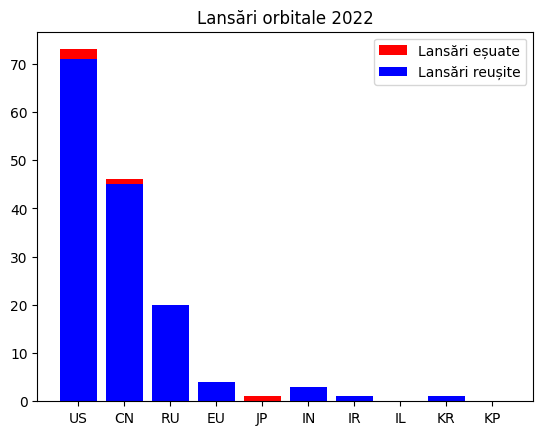

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

list_countries = ["US", "CN", "RU", "EU", "JP", "IN", "IR", "IL", "KR", "KP"]
list_slaunches = [l_succ_country[0], l_succ_country[2], l_succ_country[1], l_succ_country[3], l_succ_country[4], l_succ_country[5], l_succ_country[6], l_succ_country[7], l_succ_country[8], l_succ_country[9]]
list_tlaunches = [l_tot_country[0], l_tot_country[2], l_tot_country[1], l_tot_country[3], l_tot_country[4], l_tot_country[5], l_tot_country[6], l_tot_country[7], l_tot_country[8], l_tot_country[9]]


plt.bar(list_countries, list_tlaunches, color="r", label="Lansări eșuate")
plt.bar(list_countries, list_slaunches, color="b", label="Lansări reușite")
plt.title("Lansări orbitale %s" % str(curr_year))
plt.legend()
plt.show()
plt.close()